In [58]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import scipy.linalg
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [59]:
class Network():
    def __init__(self, T = None, n_min = None, K = None, N = None, L = None, W_in = None, W = None,
                 u = None, y_teach = None, initial_state = None, f = None, f_out = None):
        
        #NEED TO BE DEFINED BY THE USER:
        self.T = T #number of training time steps (integer)
        self.n_min = n_min #time steps dismissed (integer)
        
        self.K = K #dimension of the input (integer) (may be None)
        self.N = N #dimension of the reservoir, i.e, number of nodes (integer)
        self.L = L #dimension of the output (integer)
        
        self.W_in = W_in #input connections 
        self.W = W #adjacency matrix (matrix of size self.N x self.N)
        
        self.u = u #input
        self.y_teach = y_teach #desired output of the network
        
        self.initial_state = initial_state #initial state of the reservoir
        self.f = f #activation function of the reservoir
        self.f_out = f_out #activation function of the output
        
        #NOT NEED TO BE DEFINED BY THE USER
        self.trajectories = None #matrix storing the dynamics of the reservoir: columns -> nodes; rows -> time steps
        
        
    
    def dismiss_transient_traj(self):
        self.trajectories = self.trajectories[self.n_min:,:]
        return  self
    
    def dismiss_transient_teach(self):
        self.y_teach = self.y_teach[self.n_min:]
        return self
    
    
    def compute_nodes_trajectories(self): #assumes there are no feedback connections
        self.trajectories = self.initial_state
        x_prev = self.initial_state

        for n in np.arange(self.T):
            x = np.tanh(np.dot(self.W_in,self.u[n])+np.dot(self.W,x_prev))
            self.trajectories = np.vstack((self.trajectories,x))
            x_prev = x
            
        self.trajectories = self.trajectories[1:,:]
        
        return self
    
    
    def plot_nodes_trajectories(self, sel_nodes=False, num_nodes=10):
        if sel_nodes == False:
            nodes_to_plot = random.sample(range(self.N),num_nodes) #select num_nodes random nodes
        else:
            nodes_to_plot = sel_nodes
        
        t = np.arange(self.T) #time steps
        for node in nodes_to_plot:
            plt.plot(t, self.trajectories[:,node])  
            plt.title("Trajectories of the node {}".format(node))
            plt.show()

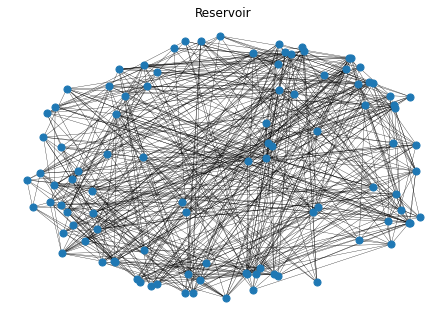

The reservoir has 100 nodes and 518 edges


In [60]:
########################
# Initialize instance
########################
Network = Network()

########################
# Define the parameters
########################

Network.T = 300
Network.n_min = 100
Network.K = 1
Network.N = 100
Network.L = 1

Network.u = np.sin(np.arange(Network.T)/5)
Network.y_teach = 0.5*Network.u**7

Network.f = "tanh"
Network.f_out = "tanh"
Network.initial_state = np.ones(Network.N)


Network.W_in = random.choices([-1,1], k=Network.N*Network.K)
Network.W_in = np.asarray(Network.W_in)



########################
# Reservoir
########################

Network.W = np.zeros([Network.N,Network.N]) #adjacency matrix

for i in np.arange(Network.N):
    for j in np.arange(Network.N):
        p = np.random.uniform()
        if 0<= p <0.025:
            Network.W[i,j] = 0.4            
            
        elif 0.025 <= p <0.05:
            Network.W[i,j] = -0.4
            

G=nx.from_numpy_matrix(Network.W)
nx.draw(G, pos=nx.spring_layout(G), width = 0.3, node_size=50)
plt.title('Reservoir')
plt.show()

print('The reservoir has {} nodes and {} edges'.format(G.number_of_nodes(), G.number_of_edges()))            


In [61]:
Network.compute_nodes_trajectories()
print(Network.trajectories.shape)#columns -> nodes; rows -> time steps

(300, 100)


In [62]:
Network.dismiss_transient_traj()
Network.dismiss_transient_teach()

In [63]:
regressor = LinearRegression()  
regressor.fit(Network.trajectories, np.arctanh(Network.y_teach))

LinearRegression()

In [64]:
print("The training MSE is {}".format(mean_squared_error(np.arctanh(Network.y_teach), regressor.predict(Network.trajectories))))

The training MSE is 1.8823616414575496e-25


In [70]:
#input vector for the test
input_vector = np.sin(np.arange(300,600)/5)
y_ground_truth = 0.5*input_vector**7

#computing the trajectories of the reservoir
trajectories = Network.trajectories[-1,:]
x_prev = Network.trajectories[-1,:]
#trajectories = np.ones(Network.N)
#x_prev = np.ones(Network.N)

for n in np.arange(len(input_vector)):
    x = np.tanh(np.dot(Network.W_in, input_vector[n])+np.dot(Network.W,x_prev))
    trajectories = np.vstack((trajectories,x))
    x_prev = x
    
#predict
y_pred = np.tanh(regressor.predict(trajectories))
print("The test MSE is {}".format(mean_squared_error(np.arctanh(y_ground_truth), y_pred[1:])))

The test MSE is 0.0002824189907177178


<function matplotlib.pyplot.show(close=None, block=None)>

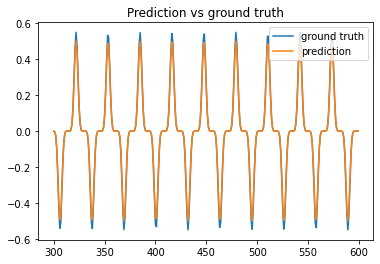

In [71]:
plt.plot(np.arange(300,600), np.arctanh(y_ground_truth), label='ground truth')
plt.plot(np.arange(300,600), y_pred[1:], label='prediction')
plt.legend()
plt.title('Prediction vs ground truth')
plt.show